In [ ]:
import os
import cv2
import random
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

# === CONFIG ===
TEXT_FILE = "data_clean/combine_clean.txt"
FONT_DIR = "fonts"  # Folder containing all .ttf fonts
OUTPUT_IMAGE_DIR = "images"
OUTPUT_YOLO_DIR = "labels"
OUTPUT_XML_DIR = "xml_labels"

# === A4 PARAMETERS (at 96 DPI) ===
# A4 size: 210mm x 297mm
DPI = 96
IMAGE_WIDTH = int(210 * DPI / 25.4)   # ~794 pixels
IMAGE_HEIGHT = int(297 * DPI / 25.4)  # ~1123 pixels

# Margins in cm converted to pixels
LEFT_MARGIN_MIN = int(1.8 * DPI / 2.54)   # ~68 pixels
LEFT_MARGIN_MAX = int(2.0 * DPI / 2.54)   # ~76 pixels
RIGHT_MARGIN_MIN = int(1.5 * DPI / 2.54)  # ~57 pixels
RIGHT_MARGIN_MAX = int(1.8 * DPI / 2.54)  # ~68 pixels
TOP_MARGIN = int(1.5 * DPI / 2.54)        # ~57 pixels
BOTTOM_MARGIN = int(1.5 * DPI / 2.54)     # ~57 pixels

# Font and spacing
FONT_SIZE_MIN = 9
FONT_SIZE_MAX = 30
LINE_SPACING = 8
WORD_SPACING = 5  # Single space between words

# === CREATE OUTPUT FOLDERS ===
os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
os.makedirs(OUTPUT_YOLO_DIR, exist_ok=True)
os.makedirs(OUTPUT_XML_DIR, exist_ok=True)

# === LOAD FONTS FROM FOLDER ===
FONTS = [os.path.join(FONT_DIR, f) for f in os.listdir(FONT_DIR) if f.endswith(".ttf")]
if not FONTS:
    raise Exception(f"No .ttf fonts found in {FONT_DIR} folder!")

print(f"Loaded {len(FONTS)} fonts from {FONT_DIR}")

# === READ KHMER CLEANED TEXT ===
with open(TEXT_FILE, "r", encoding="utf-8") as f:
    all_words = [line.strip() for line in f if line.strip()]

# === GENERATE IMAGES ===
image_count = 0
word_index = 0

while word_index < len(all_words):
    image_count += 1

    # Random parameters for this image
    font_path = random.choice(FONTS)
    font_size = random.randint(FONT_SIZE_MIN, FONT_SIZE_MAX)
    left_margin = random.randint(LEFT_MARGIN_MIN, LEFT_MARGIN_MAX)
    right_margin = random.randint(RIGHT_MARGIN_MIN, RIGHT_MARGIN_MAX)

    font = ImageFont.truetype(font_path, font_size)
    img = Image.new("RGB", (IMAGE_WIDTH, IMAGE_HEIGHT), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    # Calculate usable width
    usable_width = IMAGE_WIDTH - left_margin - right_margin

    x, y = left_margin, TOP_MARGIN
    word_boxes = []
    line_id = 1
    paragraph_id = 1
    current_line_words = []

    # Fill the page with words
    page_full = False
    while word_index < len(all_words) and not page_full:
        word = all_words[word_index]

        # Get word dimensions (no space added)
        bbox = draw.textbbox((x, y), word, font=font)
        word_width = bbox[2] - bbox[0]
        word_height = bbox[3] - bbox[1]

        # Check if word fits on current line
        if x + word_width > left_margin + usable_width:
            # Move to next line
            if current_line_words:
                line_id += 1
            current_line_words = []
            y += word_height + LINE_SPACING
            x = left_margin

            # Check if we've reached bottom margin
            if y + word_height > IMAGE_HEIGHT - BOTTOM_MARGIN:
                page_full = True
                break

            # Recalculate bbox for new position
            bbox = draw.textbbox((x, y), word, font=font)
            word_width = bbox[2] - bbox[0]
            word_height = bbox[3] - bbox[1]

        # Draw the word without space
        draw.text((x, y), word, font=font, fill=(0, 0, 0))

        # Store word info
        xmin = x
        ymin = y
        xmax = bbox[2]
        ymax = bbox[3]

        word_boxes.append({
            'text': word,
            'bbox': (xmin, ymin, xmax, ymax),
            'line_id': line_id,
            'paragraph_id': paragraph_id
        })

        current_line_words.append(word)
        x += word_width
        word_index += 1

    # Convert PIL to OpenCV format
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    image_name = f"kh_data_{image_count}.png"
    image_path = os.path.join(OUTPUT_IMAGE_DIR, image_name)
    cv2.imwrite(image_path, img_cv)

    # === GENERATE YOLO LABEL ===
    yolo_lines = []
    for word_data in word_boxes:
        xmin, ymin, xmax, ymax = word_data['bbox']
        x_center = ((xmin + xmax) / 2) / IMAGE_WIDTH
        y_center = ((ymin + ymax) / 2) / IMAGE_HEIGHT
        width = (xmax - xmin) / IMAGE_WIDTH
        height = (ymax - ymin) / IMAGE_HEIGHT
        yolo_lines.append(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    with open(os.path.join(OUTPUT_YOLO_DIR, f"kh_data_{image_count}.txt"), "w", encoding="utf-8") as f:
        f.write("\n".join(yolo_lines))

    # === GENERATE XML LABEL (matching your format) ===
    root = ET.Element("metadata")
    ET.SubElement(root, "image").text = image_name
    ET.SubElement(root, "width").text = str(IMAGE_WIDTH)
    ET.SubElement(root, "height").text = str(IMAGE_HEIGHT)

    # Group words by paragraph and line
    paragraphs = {}
    for word_data in word_boxes:
        para_id = word_data['paragraph_id']
        line_id = word_data['line_id']

        if para_id not in paragraphs:
            paragraphs[para_id] = {}
        if line_id not in paragraphs[para_id]:
            paragraphs[para_id][line_id] = []

        paragraphs[para_id][line_id].append(word_data)

    # Build XML structure
    for para_id in sorted(paragraphs.keys()):
        paragraph = ET.SubElement(root, "paragraph")
        if para_id > 0:
            paragraph.set("id", str(para_id))

        for line_id in sorted(paragraphs[para_id].keys()):
            line = ET.SubElement(paragraph, "line", id=str(line_id))

            for word_data in paragraphs[para_id][line_id]:
                word_elem = ET.SubElement(line, "word")
                text_elem = ET.SubElement(word_elem, "text")
                text_elem.text = word_data['text']

                xmin, ymin, xmax, ymax = word_data['bbox']
                bbox_elem = ET.SubElement(word_elem, "bbox")
                bbox_elem.set("x1", str(int(xmin)))
                bbox_elem.set("y1", str(int(ymin)))
                bbox_elem.set("x2", str(int(xmax)))
                bbox_elem.set("y2", str(int(ymax)))

    # Write XML file
    tree = ET.ElementTree(root)
    ET.indent(tree, space="", level=0)  # Python 3.9+
    xml_path = os.path.join(OUTPUT_XML_DIR, f"kh_data_{image_count}.xml")
    tree.write(xml_path, encoding="utf-8", xml_declaration=True)

    print(f"Generated {image_name} ({len(word_boxes)} words) using {os.path.basename(font_path)} size {font_size}")

print(f"\nGenerated {image_count} images with YOLO and XML annotations!")
print(f"Total words processed: {word_index}/{len(all_words)}")

🧩 Loaded 16 fonts from fonts
✅ Generated kh_data_1.png (219 words) using KhmerMPTC.ttf size 29
✅ Generated kh_data_2.png (901 words) using KhmerDigital-Bold.ttf size 13
✅ Generated kh_data_3.png (314 words) using KhmerDigital-Medium.ttf size 23
✅ Generated kh_data_4.png (319 words) using KhmerMPTC-Bold.ttf size 20
✅ Generated kh_data_5.png (216 words) using KhmerDigital-Thin.ttf size 28
✅ Generated kh_data_6.png (1265 words) using KhmerDigitalMax.ttf size 9
✅ Generated kh_data_7.png (466 words) using KhmerDigital-Regular.ttf size 20
✅ Generated kh_data_8.png (477 words) using KhmerDigital-Medium.ttf size 19
✅ Generated kh_data_9.png (272 words) using KhmerDigital-Black.ttf size 25
✅ Generated kh_data_10.png (514 words) using KhmerDigital-SemiBold.ttf size 18
✅ Generated kh_data_11.png (415 words) using KhmerMPTC.ttf size 19
✅ Generated kh_data_12.png (283 words) using KhmerOS_siemreap.ttf size 22
✅ Generated kh_data_13.png (163 words) using KhmerDigitalMax.ttf size 29
✅ Generated kh_da

KeyboardInterrupt: 

Testing Khmer Text Detection Dataset

Available files:
Images: 108 files
  - kh_data_1.png
  - kh_data_10.png
  - kh_data_11.png
  - kh_data_12.png
  - kh_data_13.png
YOLO Labels: 108 files
XML Labels: 108 files

Displaying images with YOLO annotations...


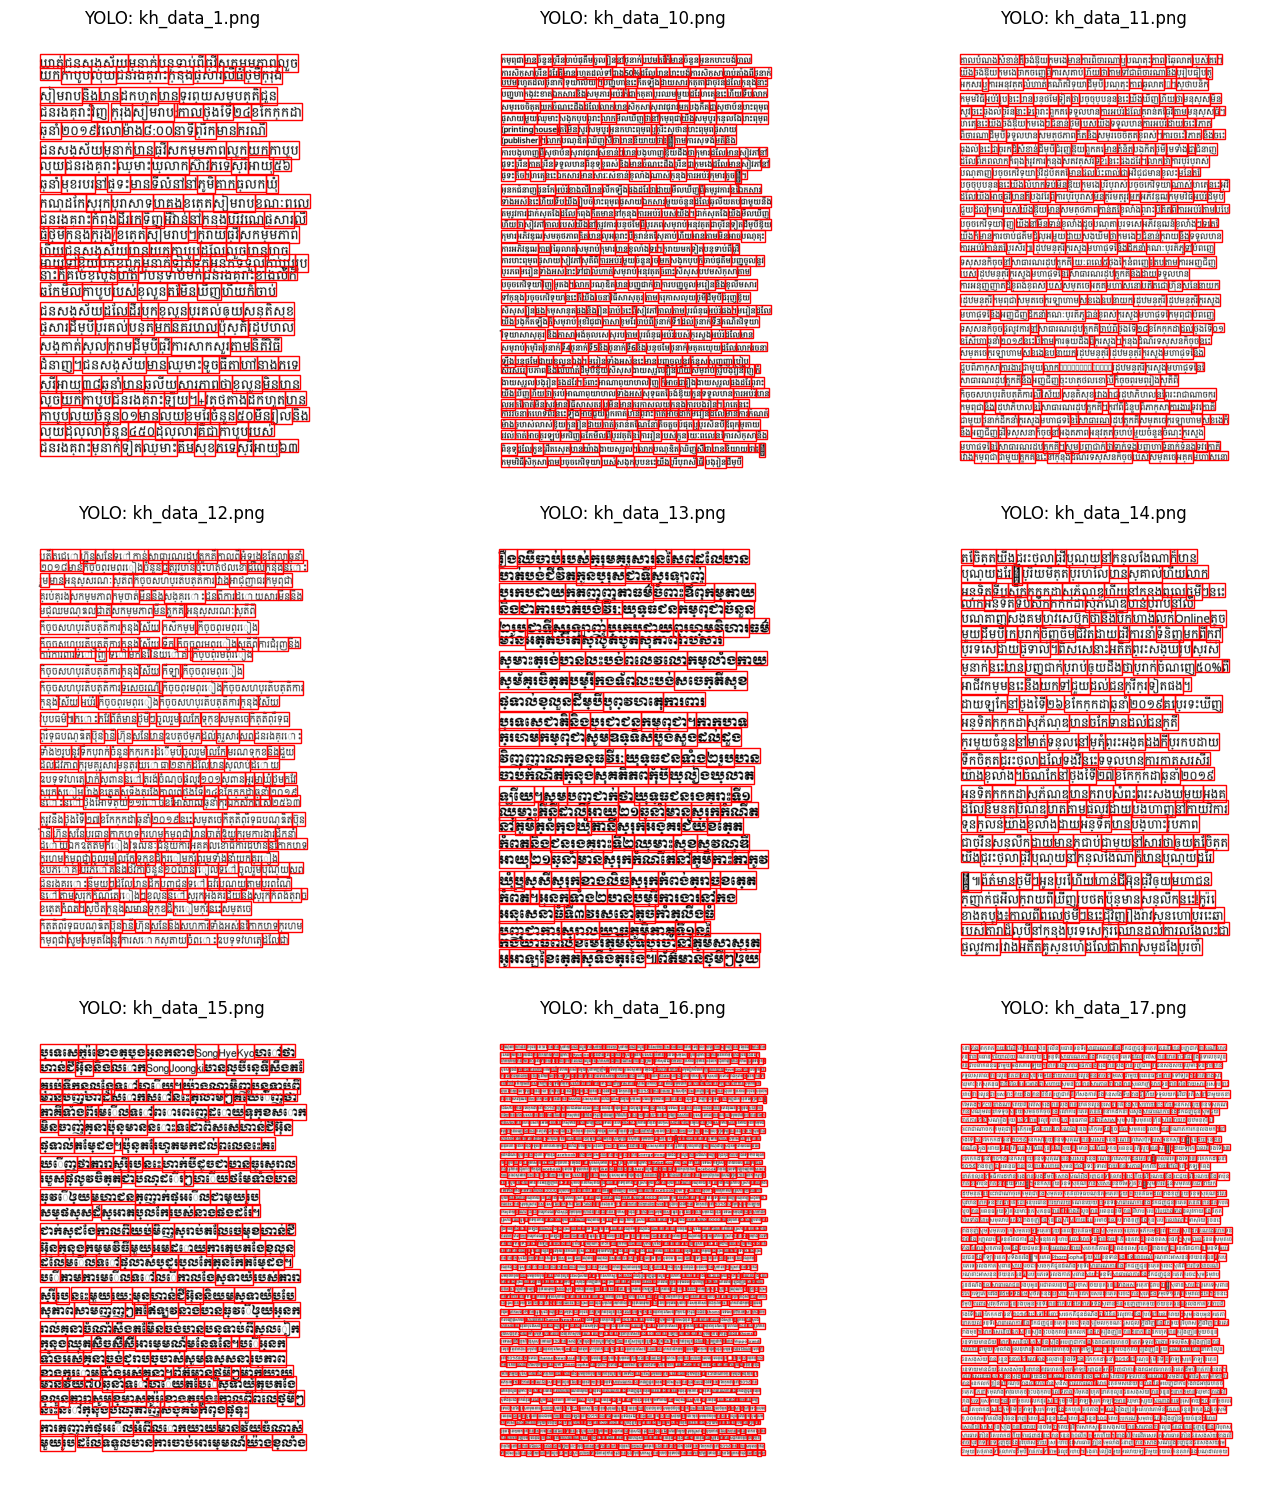


Displaying images with XML annotations...


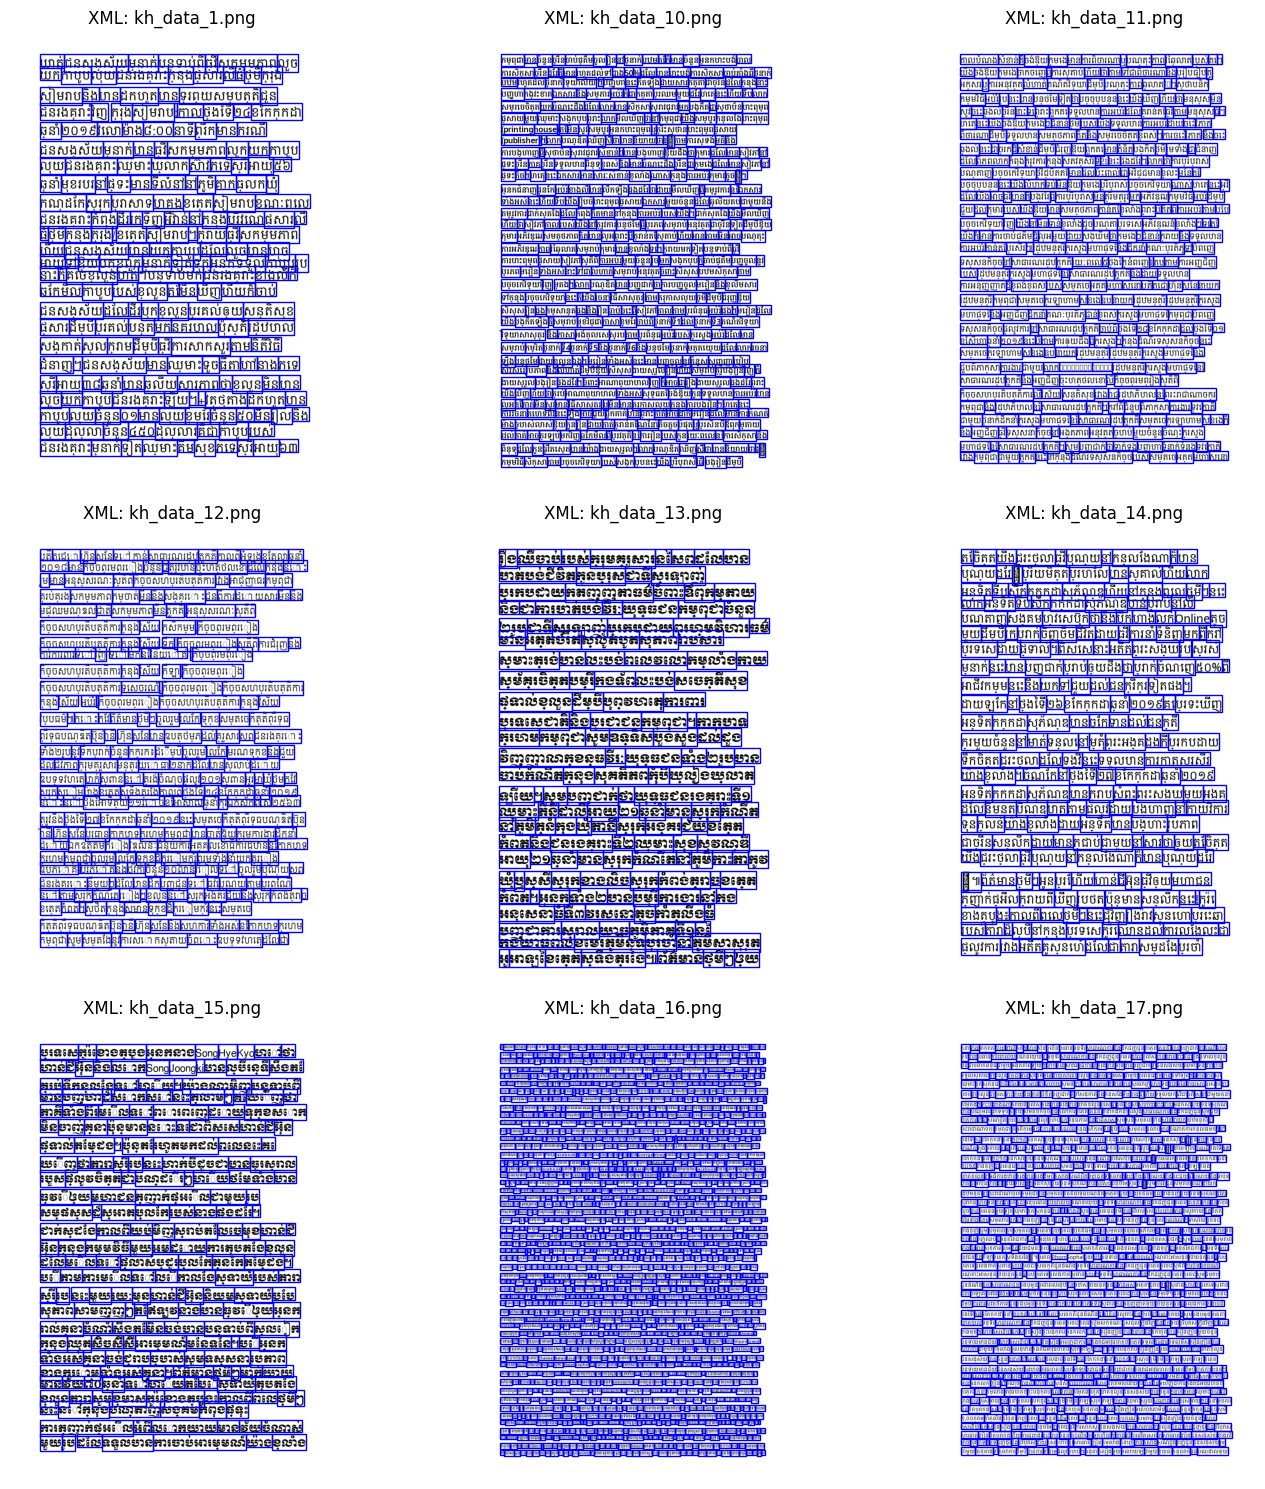


Comparing YOLO vs XML annotations for first image...


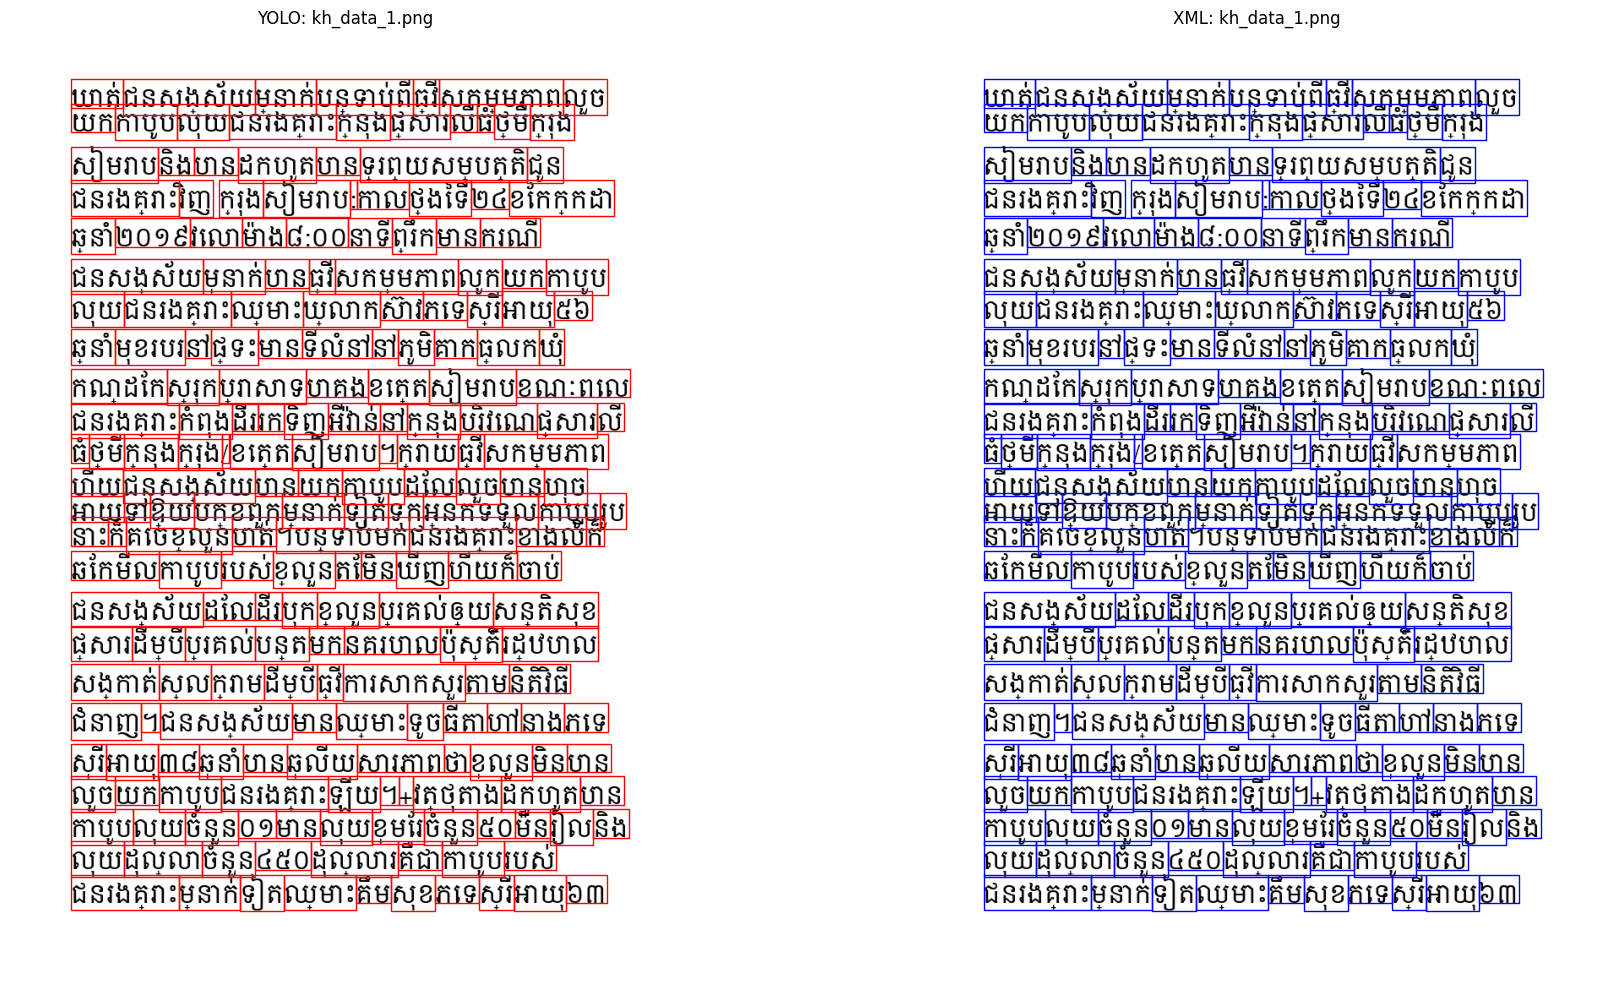

In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import xml.etree.ElementTree as ET

# Function to plot a single image with its YOLO bounding boxes
def plot_image_with_bbox(ax, img_path, label_path):
    try:
        # Open the image
        image = Image.open(img_path)

        # Read all YOLO labels
        with open(label_path, "r") as f:
            labels = f.readlines()

        # Plot the image
        ax.imshow(image)
        ax.axis("off")

        # Get image dimensions
        image_width, image_height = image.size

        # Loop through each label and draw the bounding box
        for label in labels:
            label = label.strip().split()
            if len(label) == 5:  # Ensure it's a valid YOLO format line
                class_id, x_center, y_center, w, h = map(float, label)

                # Convert normalized YOLO coordinates to pixel coordinates
                x_center *= image_width
                y_center *= image_height
                w *= image_width
                h *= image_height

                # Calculate the top-left corner of the bounding box
                x_min = x_center - w / 2
                y_min = y_center - h / 2

                # Add the bounding box
                rect = patches.Rectangle(
                    (x_min, y_min), w, h, linewidth=1, edgecolor="red", facecolor="none"
                )
                ax.add_patch(rect)

        ax.set_title(f"YOLO: {os.path.basename(img_path)}")

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        ax.axis("off")

# Function to plot a single image with its XML bounding boxes
def plot_image_with_xml_bbox(ax, img_path, xml_path):
    try:
        # Open the image
        image = Image.open(img_path)

        # Parse XML
        tree = ET.parse(xml_path)
        root = tree.getroot()

        # Plot the image
        ax.imshow(image)
        ax.axis("off")

        # Get image dimensions from XML
        width = int(root.find('width').text)
        height = int(root.find('height').text)

        # Extract all word bounding boxes
        for line in root.findall('.//line'):
            for word in line.findall('word'):
                bbox = word.find('bbox')
                x1 = float(bbox.get('x1'))
                y1 = float(bbox.get('y1'))
                x2 = float(bbox.get('x2'))
                y2 = float(bbox.get('y2'))

                # Create rectangle
                rect = patches.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    linewidth=1, edgecolor="blue", facecolor="none"
                )
                ax.add_patch(rect)

        ax.set_title(f"XML: {os.path.basename(img_path)}")

    except Exception as e:
        print(f"Error processing {img_path}: {e}")
        ax.axis("off")

# Display images with YOLO labels
def display_images_with_yolo(image_dir, label_dir, num_images=9):
    # Get all image files
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

    # Calculate how many images to display
    num_to_display = min(num_images, len(image_files))

    # Create subplots
    rows = int(num_to_display ** 0.5)
    cols = (num_to_display + rows - 1) // rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    if num_to_display == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Display images
    for i in range(num_to_display):
        img_filename = image_files[i]
        img_path = os.path.join(image_dir, img_filename)

        # Create corresponding label filename
        base_name = os.path.splitext(img_filename)[0]
        label_path = os.path.join(label_dir, base_name + '.txt')

        if os.path.exists(label_path):
            plot_image_with_bbox(axes[i], img_path, label_path)
        else:
            print(f"Label file not found: {label_path}")
            axes[i].axis("off")

    # Hide empty subplots
    for i in range(num_to_display, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Display images with XML labels
def display_images_with_xml(image_dir, xml_dir, num_images=9):
    # Get all image files
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

    # Calculate how many images to display
    num_to_display = min(num_images, len(image_files))

    # Create subplots
    rows = int(num_to_display ** 0.5)
    cols = (num_to_display + rows - 1) // rows
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

    if num_to_display == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Display images
    for i in range(num_to_display):
        img_filename = image_files[i]
        img_path = os.path.join(image_dir, img_filename)

        # Create corresponding XML filename
        base_name = os.path.splitext(img_filename)[0]
        xml_path = os.path.join(xml_dir, base_name + '.xml')

        if os.path.exists(xml_path):
            plot_image_with_xml_bbox(axes[i], img_path, xml_path)
        else:
            print(f"XML file not found: {xml_path}")
            axes[i].axis("off")

    # Hide empty subplots
    for i in range(num_to_display, len(axes)):
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Function to compare YOLO vs XML annotations for the same image
def compare_annotations(image_dir, label_dir, xml_dir, image_index=0):
    # Get all image files
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

    if image_index >= len(image_files):
        print(f"Image index {image_index} out of range. Only {len(image_files)} images available.")
        return

    img_filename = image_files[image_index]
    base_name = os.path.splitext(img_filename)[0]

    img_path = os.path.join(image_dir, img_filename)
    yolo_path = os.path.join(label_dir, base_name + '.txt')
    xml_path = os.path.join(xml_dir, base_name + '.xml')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Plot YOLO annotations
    if os.path.exists(yolo_path):
        plot_image_with_bbox(ax1, img_path, yolo_path)
    else:
        ax1.axis("off")
        ax1.set_title(f"YOLO labels not found: {base_name}.txt")

    # Plot XML annotations
    if os.path.exists(xml_path):
        plot_image_with_xml_bbox(ax2, img_path, xml_path)
    else:
        ax2.axis("off")
        ax2.set_title(f"XML labels not found: {base_name}.xml")

    plt.tight_layout()
    plt.show()

# Test your dataset
print("Testing Khmer Text Detection Dataset")

# Check what files we have
image_dir = "images"
label_dir = "labels"
xml_dir = "xml_labels"

# List available files
print("\nAvailable files:")
if os.path.exists(image_dir):
    images = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    print(f"Images: {len(images)} files")
    for img in images[:5]:  # Show first 5
        print(f"  - {img}")

if os.path.exists(label_dir):
    labels = sorted([f for f in os.listdir(label_dir) if f.endswith('.txt')])
    print(f"YOLO Labels: {len(labels)} files")

if os.path.exists(xml_dir):
    xmls = sorted([f for f in os.listdir(xml_dir) if f.endswith('.xml')])
    print(f"XML Labels: {len(xmls)} files")

# Display images with YOLO annotations
print("\nDisplaying images with YOLO annotations...")
display_images_with_yolo(image_dir, label_dir, num_images=9)

# Display images with XML annotations
print("\nDisplaying images with XML annotations...")
display_images_with_xml(image_dir, xml_dir, num_images=9)

# Compare both annotation types for the first image
print("\nComparing YOLO vs XML annotations for first image...")
compare_annotations(image_dir, label_dir, xml_dir, image_index=0)